In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
paths = ['Data/tagaddod-d8ffe--MsZkGFSCtYxntenMuVF-export.json',
         'Data/tagaddod-d8ffe--MszT9RZtTjcM5PwTCBH-export.json',
         'Data/tagaddod-d8ffe--MwWeqpG3yuQD7G2wcp8-export.json',
         'Data/tagaddod-d8ffe--N4SUsENXI1OF1qf8VxT-export.json']

In [3]:
class Solution:
    
    def __init__(self, path):
        self.path = path
    
    def extract_transform(self, plot=False, load=False, drop_outliers=False):
        """
        Extract and transform data into a mapping-ready format
        
        Parameters:
        -----------
        plot : bool, default: False
            Plotting transformed data on world map.
        load : bool, default: False
            Printing data out to csv file.
        drop_outliers: bool, default: False
            Dropping outliers based on Egypt geographical locations.
        
        Returns:
        --------
        result: Pandas DataFrame
            dataframe contains the transformed data (csv format).
        """
        # Data extraction
        df = pd.read_json(self.path)
        
        # Data transpose
        df_transposed = df.transpose(copy=True)
        
        # backward fill missing collector_id
        df_transposed["collector_id"] = df_transposed["collector_id"].replace(np.nan, method='bfill')
        
        ## Correcting dtypes
        # -> correcting geolocations -- large floats interpreted as strings (pandas default)
        # -> 6 decimal places for longitude & latitude ~ 11.1 cm accuracy
        df_transposed[["longitude", "latitude"]] = df_transposed[["longitude", "latitude"]].astype('float')
        
        # -> convert snapshot_datetime to date-time format
        df_transposed["snapshot_datetime"] = pd.to_datetime(df_transposed["snapshot_datetime"])
        
        # -> though collector_id are strings they are unique, searchable, short (fulfilling their purpose)
        
        # Deleting duplicated latitude AND longitude (collector is standing still)
        df_transposed.drop_duplicates(subset=['latitude', 'longitude'], keep='last', inplace=True)
        
        # Drop missing location Co-ordinates (Whilst keeping meta-data as it is)
        df_transposed.iloc[:-1] = df_transposed.iloc[:-1].dropna(subset=['latitude', 'longitude'])
        
        ## Filling missing vals
        # -> device_id missing values ~ 'N/A'
        if 'N/A' in df_transposed["device_id"].unique():
            df_transposed.loc[df_transposed['device_id'] == 'N/A', 'device_id'] = -1
        
        # -> where: -1 indicates missing value (multiple scenarios could occur)
        df_transposed.iloc[:-1] = df_transposed.iloc[:-1].replace(np.nan, -1)
        
        # Excluding meta-data column/row from output results
        result = df_transposed.loc[:, ~df_transposed.columns.isin(['meta-data'])][:-1]
        
        ## Revmoving outliers based on geo-locations (Optional)
        if drop_outliers:
            result.drop(result.loc[~((result['latitude'] > 20) & (result['latitude'] < 32) &
                                     (result['longitude'] > 24) & (result['longitude'] < 36))].index,
                                     inplace=True)
        
        # Data points visualization (Optional)
        if plot:
            fig = px.density_mapbox(result,
                    lat='latitude',
                    lon='longitude',
                    hover_name='collector_id',
                    center=dict(lat=26.8206, lon=30.8025),    # Egypt's center co-ordinates
                    range_color = [0, 1],
                    zoom=4,
                    radius=20,
                    opacity=.7,
                    mapbox_style='open-street-map')
            fig.update_layout(title="Collector {} Geospatial locations".format(
                              result["collector_id"][0]))
            fig.show()
        
        # Generating output file (Optional)
        # .format() is used to avoid overwriting printed data
        if load:
            result.to_csv('data_transformed_{}.csv'.format(paths.index(self.path)))
        
        return result

---
---
## <font color="darkcyan">Investigating results</font>

### $1^{st}$ DataFrame

In [5]:
dataframe1 = Solution(paths[0])
result = dataframe1.extract_transform(plot=True)

In [6]:
result.describe()

,latitude,longitude
count,802.000000,802.000000
mean,29.994571,31.507879
std,0.657786,0.124171
min,27.203443,31.155542
25%,30.167200,31.566720
50%,30.167262,31.566805
75%,30.167298,31.566871
max,30.167423,31.567034



### <u><font color="darkred">Summary</font></u>

<b>No noticeable abnormality.</b>

---
### $2^{nd}$ DataFrame

In [7]:
dataframe2 = Solution(paths[1])
result = dataframe2.extract_transform(plot=True)

In [8]:
result.describe()

,latitude,longitude
count,8611.000000,8611.000000
mean,31.174878,29.998412
std,0.135235,1.055648
min,30.807432,29.576556
25%,31.183913,29.935304
50%,31.212764,29.975468
75%,31.254655,30.003095
max,37.301212,127.072758



### <u><font color="darkred">Summary</font></u>

1. **`std` value in longitude values is quite large,** indicating presence of highly deviated value(s) from the mean.
2. **`max` value in both latitude & longitude values is very large,** indicating locations outside of Egypt.
    - Using **Google maps** these co-ordinates are referring to South Korea! **(Outlier <font color="darkcyan">[Considering the business runs inside Egypt]</font>)**

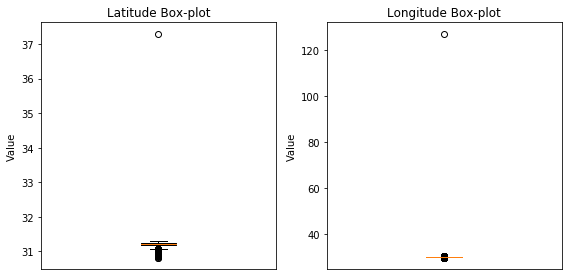

In [9]:
# Outlier visualzation using Box-plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].boxplot(result.latitude)
axs[0].set_title('Latitude Box-plot')
axs[0].get_xaxis().set_visible(False)
axs[0].set_ylabel('Value')

axs[1].boxplot(result.longitude)
axs[1].set_title('Longitude Box-plot')
axs[1].get_xaxis().set_visible(False)
axs[1].set_ylabel('Value')

plt.tight_layout()

**Removing values outside of Egypt:**
<img src="https://images.mapsofworld.com/answers/2019/07/Map-of-Egypt.jpg" width=400 title='Egypt Map'>

- Latitude values in the range of **[20 ~ 32] approx**.
- Longitude values in the range of **[24 ~ 36] approx**.

In [10]:
# setting drop_outliers param to True
result = dataframe2.extract_transform(plot=True, drop_outliers=True)

In [11]:
result.describe()

,latitude,longitude
count,8610.000000,8610.000000
mean,31.174166,29.987138
std,0.118027,0.140686
min,30.807432,29.576556
25%,31.183913,29.935301
50%,31.212750,29.975467
75%,31.254645,30.003094
max,31.299585,30.375076



### <u><font color="darkred">Modified Summary</font></u>

**Outliers** have been removed.

---
### $3^{rd}$ DataFrame

In [12]:
dataframe3 = Solution(paths[2])
result = dataframe3.extract_transform(plot=True)

In [13]:
result.describe()

,latitude,longitude
count,1070.000000,1070.000000
mean,30.144608,31.045883
std,0.209329,0.159630
min,29.938734,30.674810
25%,29.973459,30.946196
50%,30.043963,30.976545
75%,30.310796,31.054841
max,30.571211,31.323868



### <u><font color="darkred">Summary</font></u>

<b>No noticeable abnormality.</b>

---
### $4^{th}$ DataFrame

In [14]:
dataframe4 = Solution(paths[3])
result = dataframe4.extract_transform(load=True, plot=True)

In [15]:
result.describe()

,latitude,longitude
count,33.000000,33.000000
mean,30.562313,31.560081
std,0.000004,0.000007
min,30.562300,31.560071
25%,30.562313,31.560076
50%,30.562314,31.560081
75%,30.562314,31.560082
max,30.562320,31.560104



### <u><font color="darkred">Summary</font></u>

<b>No noticeable abnormality.</b>

---
---
### Sources:

- [Latitude and Longitude decimal values accuracy](http://wiki.gis.com/wiki/index.php/Decimal_degrees)
- [Egypt map co-ordinates](https://www.mapsofworld.com/answers/geography/what-are-the-key-facts-of-egypt/)